## Семинар 6 "Segmentation"

In [ ]:
# Соревнование:
# https://drive.grand-challenge.org/evaluation/challenge/submissions/create/

ФИО: __Харазян Давид Самвелович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
!pip install imagecodecs
!pip install scikit-image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io

     |████████████████████████████████| 17.9MB 207kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

cur_dir = 'drive/MyDrive/NN_sphere_2020/hw6/'

TRAIN_PATH = './train.pth'
TEST_PATH  = './test.pth'
%matplotlib inline

Mounted at /content/drive


In [3]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image, plugin='pil') # Загружаем изображение из 'tif' в np.array, dtype=uint8, 'pil' - обязательный.
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0] # name example - '02_test.tif'
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"), plugin='pil') # Не понял в чем отличие /1st_manual от /mask.
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
    
test = process(cur_dir+"test/images/")
t.save(test, TEST_PATH) ##################################################
train_data = process(cur_dir+"train/images", cur_dir+"train/1st_manual/")

In [4]:
import PIL
class Dataset():

    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img  = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy() # .byte() = make dtype of this tensor = uint8. (like - .int() or .double() or etc)
        img  = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.datas)


s_trans = tsf.Compose([tsf.ToPILImage(),
                       tsf.Resize((584,565)),
                       tsf.ToTensor(),
                       tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])])

t_trans = tsf.Compose([tsf.ToPILImage(),
                       tsf.Resize((584,565), interpolation=PIL.Image.NEAREST),
                       tsf.ToTensor()])

dataset = Dataset(train_data, s_trans, t_trans)
dataloader = t.utils.data.DataLoader(dataset, num_workers=2, batch_size=4)

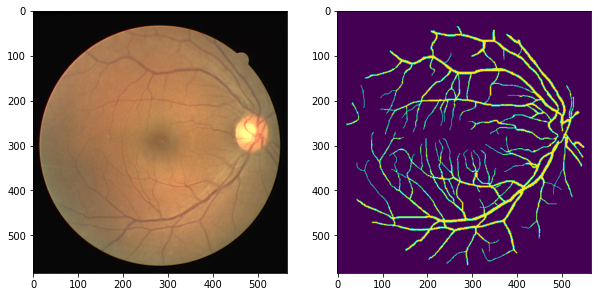

In [5]:
img, mask = dataset[17]

fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(img.permute(1,2,0).numpy()*0.5+0.5)
ax[1].imshow(mask[0].numpy());

# Основной код

In [6]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2) # Кол-во слоев уменьшается на 2, ошибка была в том что 1арг=in_ch//2.
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):

        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2)) # Добавляем нули, если размер не совп с x2.
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1) # "Глубина" x здесь увеличивается (в 2 раза, как правило).
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1, )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # print(x5.shape)
        # print(x4.shape)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        # x = t.nn.functional.sigmoid(x)
        x = t.sigmoid(x)
        return x

In [7]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [8]:
def get_pictures(model, data_set):
  
  model = model.eval()
  tmp_dataloader = t.utils.data.DataLoader(data_set, batch_size=1)

  if len(data_set[0]) == 2:
    
    fig, axes = plt.subplots(3,20, figsize=(100,7))
    for ex_id, (X, y) in enumerate(tmp_dataloader):
        X = X.to(device)

        y_pred = model.forward(X)
        
        tm = y_pred.data.cpu().numpy()
        tm = (tm > 0.5).astype(int)
        
        axes[0, ex_id].set_title(str(ex_id))
        axes[0, ex_id].imshow(tm[0,0], cmap='gray');    
        axes[1, ex_id].imshow(y[0,0],  cmap='gray');
        axes[2, ex_id].imshow(X[0].cpu().permute(1,2,0)*0.5+0.5);

    
  else:
    fig, axes = plt.subplots(2,20, figsize=(100,7))
    for ex_id, X in enumerate(tmp_dataloader):
        X = X.to(device)

        y_pred = model.forward(X)
        
        tm = y_pred.data.cpu().numpy()
        tm = (tm > 0.5).astype(int)
        
        axes[0, ex_id].set_title(str(ex_id))
        axes[0, ex_id].imshow(tm[0,0], cmap='gray');    
        axes[1, ex_id].imshow(X[0].cpu().permute(1,2,0)*0.5+0.5);    

In [9]:
def cross_val_scores(data_set, epochs_num=200, seed=7):

  all_loses = []

  N = 20
  for i in tqdm(range(N)):
#
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.backends.cudnn.deterministic = True

    model = UNet(3, 1)

    device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    model.to(device)

    loss = soft_dice_loss
    optimizer = t.optim.Adam(model.parameters(), lr=1.0e-3)
#
    X_val = data_set[i][0].unsqueeze(0).to(device)
    y_val = data_set[i][1].unsqueeze(0).to(device)

    train_list = list(range(N))
    train_list.remove(i)
  
    X = t.cat([dataset[j][0].unsqueeze(0) for j in train_list], dim=-0)
    y = t.cat([dataset[j][1].unsqueeze(0) for j in train_list], dim=-0)
  
    loss_history = [] 

    for epoch in range(epochs_num):

      model = model.train()
      for batch_num in range(N-1):
        X_train = X[batch_num].unsqueeze(0).to(device)
        y_train = y[batch_num].unsqueeze(0).to(device)
  
        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

      model = model.eval()
      y_pred = model.forward(X_val)
      loss_val_value = loss(y_pred, y_val)
      loss_history.append(loss_val_value.item())
    
    all_loses.append(loss_history)

  return all_loses

In [ ]:
lizt = cross_val_scores(dataset, 150)


100%|██████████| 20/20 [8:46:14<00:00, 1578.72s/it]


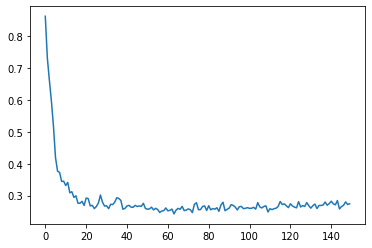

In [ ]:
cv_loss_history = np.array(lizt).mean(0)
plt.plot(cv_loss_history)

In [ ]:
for i, loss_v in enumerate(cv_loss_history): # 63
  print(i, "- %.4f" % loss_v)#, end=';  ')

0 - 0.8625
1 - 0.7319
2 - 0.6619
3 - 0.5959
4 - 0.5178
5 - 0.4194
6 - 0.3768
7 - 0.3729
8 - 0.3446
9 - 0.3452
10 - 0.3316
11 - 0.3415
12 - 0.3089
13 - 0.3123
14 - 0.2946
15 - 0.2995
16 - 0.2762
17 - 0.2761
18 - 0.2821
19 - 0.2690
20 - 0.2924
21 - 0.2908
22 - 0.2678
23 - 0.2696
24 - 0.2593
25 - 0.2660
26 - 0.2770
27 - 0.3019
28 - 0.2797
29 - 0.2673
30 - 0.2682
31 - 0.2592
32 - 0.2729
33 - 0.2720
34 - 0.2797
35 - 0.2935
36 - 0.2912
37 - 0.2849
38 - 0.2573
39 - 0.2600
40 - 0.2676
41 - 0.2696
42 - 0.2639
43 - 0.2635
44 - 0.2695
45 - 0.2659
46 - 0.2677
47 - 0.2665
48 - 0.2760
49 - 0.2599
50 - 0.2574
51 - 0.2585
52 - 0.2638
53 - 0.2552
54 - 0.2602
55 - 0.2566
56 - 0.2473
57 - 0.2517
58 - 0.2530
59 - 0.2614
60 - 0.2524
61 - 0.2538
62 - 0.2578
63 - 0.2427
64 - 0.2545
65 - 0.2601
66 - 0.2571
67 - 0.2663
68 - 0.2531
69 - 0.2545
70 - 0.2585
71 - 0.2557
72 - 0.2468
73 - 0.2729
74 - 0.2777
75 - 0.2558
76 - 0.2563
77 - 0.2661
78 - 0.2676
79 - 0.2535
80 - 0.2683
81 - 0.2555
82 - 0.2595
83 - 0.2575
84

In [10]:
# # Предобученная модель: https://github.com/qubvel/segmentation_models.pytorch

# import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )

In [11]:
k = 7
t.manual_seed(k)
t.cuda.manual_seed(k)
t.backends.cudnn.deterministic = True

model = UNet(3, 1)

device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
model.to(device)

loss = soft_dice_loss
optimizer = t.optim.Adam(model.parameters(), lr=1.0e-3)

In [12]:
dataloader = t.utils.data.DataLoader(dataset, num_workers=2, batch_size=1)
loss_history = [] #lr=1.0e-3
model = model.train()
N = 63

for epoch in range(N):
  
  batch_losses = []
  print('epoch №%i,' % epoch, end=' ')
  for X, y in dataloader:

      X = X.to(device)
      y = y.to(device)
  
      optimizer.zero_grad()

      y_pred = model.forward(X)

      loss_value = loss(y_pred, y)
      loss_value.backward()

      batch_losses.append(loss_value.item())

      optimizer.step()

  loss_history.append(np.mean(batch_losses))
  print('loss - %.4f' % loss_history[-1])

epoch №0, loss - 0.7156
epoch №1, loss - 0.6258
epoch №2, loss - 0.5653
epoch №3, loss - 0.4811
epoch №4, loss - 0.4038
epoch №5, loss - 0.3373
epoch №6, loss - 0.2952
epoch №7, loss - 0.2727
epoch №8, loss - 0.2565
epoch №9, loss - 0.2434
epoch №10, loss - 0.2353
epoch №11, loss - 0.2330
epoch №12, loss - 0.2289
epoch №13, loss - 0.2227
epoch №14, loss - 0.2202
epoch №15, loss - 0.2155
epoch №16, loss - 0.2161
epoch №17, loss - 0.2117
epoch №18, loss - 0.2113
epoch №19, loss - 0.2098
epoch №20, loss - 0.2064
epoch №21, loss - 0.2076
epoch №22, loss - 0.2032
epoch №23, loss - 0.2038
epoch №24, loss - 0.2015
epoch №25, loss - 0.1980
epoch №26, loss - 0.1970
epoch №27, loss - 0.1942
epoch №28, loss - 0.1928
epoch №29, loss - 0.1919
epoch №30, loss - 0.1901
epoch №31, loss - 0.1938
epoch №32, loss - 0.1913
epoch №33, loss - 0.1916
epoch №34, loss - 0.1903
epoch №35, loss - 0.1894
epoch №36, loss - 0.1875
epoch №37, loss - 0.1851
epoch №38, loss - 0.1834
epoch №39, loss - 0.1836
epoch №40,

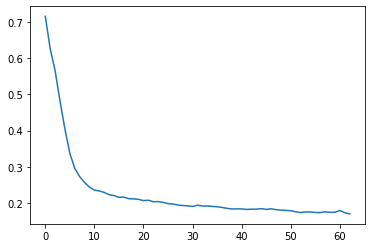

In [13]:
plt.plot(loss_history);

In [14]:
class TestDataset():

    def __init__(self, path, source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img

    def __len__(self):
        return len(self.datas)


testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

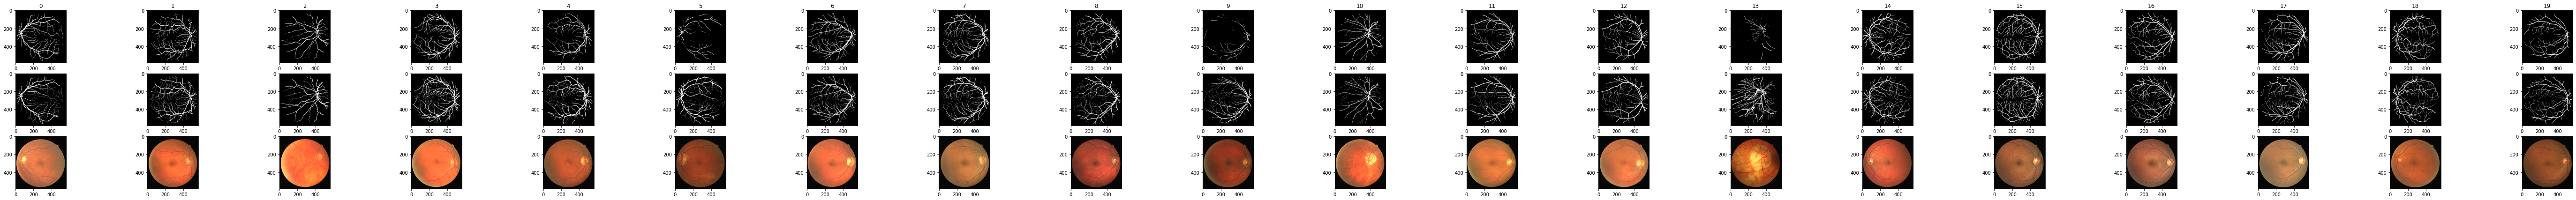

In [15]:
get_pictures(model, dataset);

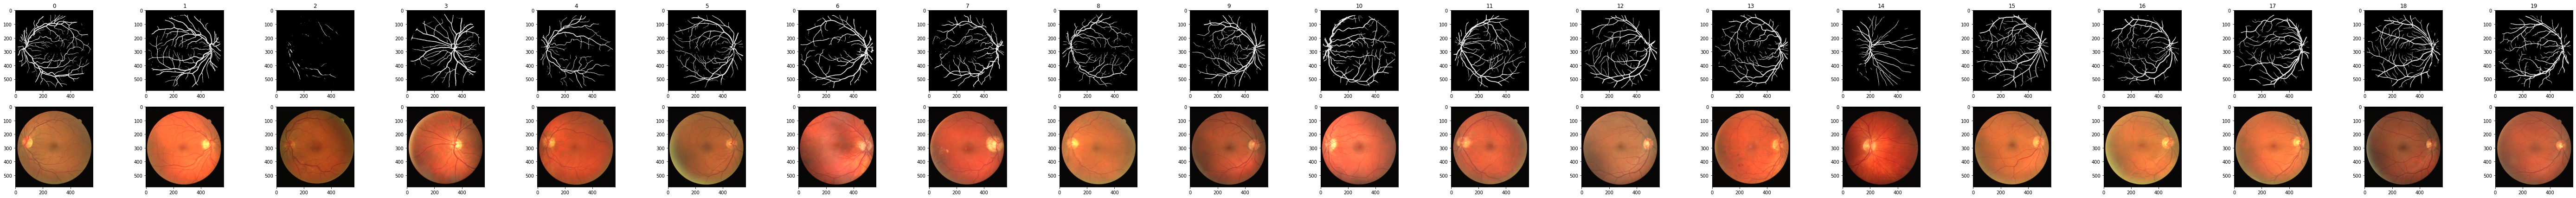

In [16]:
get_pictures(model, testset)

In [17]:
os.makedirs("result")
# os.makedirs(cur_dir+"test/"+"result")
# !zip -r result.zip result

In [18]:
import imageio

model = model.eval()
for ex_id, data in enumerate(testdataloader):
    #data = t.autograd.Variable(data, volatile=True).cuda()
    data = data.to(device)
    o = model(data)
    
    source_image = io.imread(cur_dir+"test/images/%s_test.tif" % str(ex_id + 1).zfill(2), plugin='pil')
    o = tsf.Resize((584,565), interpolation=PIL.Image.NEAREST)(o)
    tm = o[0][0].data.cpu().numpy()
    #tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    # imageio.imwrite(cur_dir+"test/result/%s.png" % (ex_id + 1), tm.astype(np.uint8))
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm.astype(np.uint8))

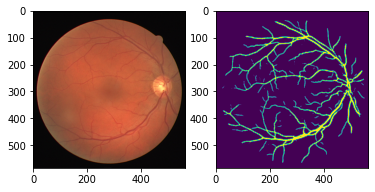

In [19]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm);

In [20]:
!zip -r result.zip result

  adding: result/ (stored 0%)
  adding: result/1.png (deflated 1%)
  adding: result/12.png (deflated 1%)
  adding: result/20.png (deflated 1%)
  adding: result/11.png (deflated 1%)
  adding: result/8.png (deflated 1%)
  adding: result/16.png (deflated 1%)
  adding: result/15.png (deflated 1%)
  adding: result/18.png (deflated 1%)
  adding: result/3.png (deflated 3%)
  adding: result/7.png (deflated 1%)
  adding: result/5.png (deflated 1%)
  adding: result/10.png (deflated 1%)
  adding: result/13.png (deflated 1%)
  adding: result/6.png (deflated 1%)
  adding: result/14.png (deflated 1%)
  adding: result/17.png (deflated 1%)
  adding: result/19.png (deflated 1%)
  adding: result/9.png (deflated 1%)
  adding: result/2.png (deflated 1%)
  adding: result/4.png (deflated 1%)
